# Concurrency for building recommendation system

## Imports

In [3]:
import sys
sys.path.append("../")

In [54]:
from collections import defaultdict
import pandas as pd
import typing as tp
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

from src.utils import rec_imaging

## Data preparation

In [5]:
interactions = pd.read_csv("../data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("../data/BX-Books.csv", low_memory=False)
users = pd.read_csv("../data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [6]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [7]:
interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "score",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [8]:
interactions = interactions[interactions["item_name"].notna()]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

In [9]:
interactions = (
    interactions
    .groupby(["user_id", "item_id"])
    .agg({
        "score": "sum",
        "item_name": "first",
        "image_url": "first"
    })
    .reset_index()
)

## Model

In [79]:
class Concurrency:
    def __init__(
        self,
        interactions_df: pd.DataFrame,
    ) -> None:
        self.content_dict = {}
        self.interactions_df = interactions_df

        # Fill dict with content
        for i, j, k in self.interactions_df[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

        self.interactions_df = self.interactions_df[["user_id", "item_id", "score"]]

        
    def coocurrency_count(self) -> None:
        # For each user collect all items he interacted with
        user_to_items_list_df = (
            self.interactions_df
            .groupby("user_id")
            [["item_id", "score"]]
            .agg(list)
            .reset_index()
        )

        # Count number of unique items each user interacted with
        user_to_items_list_df["item_num"] = [len(i) for i in user_to_items_list_df["item_id"]]
        # Filter users who have only only one interaction
        user_to_items_list_df = (
            user_to_items_list_df
            [user_to_items_list_df["item_num"] > 1]
            [user_to_items_list_df["item_num"] < 100]
        )
        # Create and fill concurrency dict
        cooc = defaultdict(int)
        for row in tqdm(user_to_items_list_df.values):
            items_list = row[1]
            scores_list = row[2]
            for i in range(len(row[1])):
                for j in range(len(row[1])):
                    if i != j:
                        mean_score = (scores_list[i] + scores_list[j]) / 2
                        key = str(items_list[i]) + "_" + str(items_list[j])
                        cooc[key] += mean_score

        cooc_list = []
        for key, val in cooc.items():
            # If items were together more than one time, add them to list
            if val != 1:
                cooc_list.append(key.split("_") + [val])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(
        self,
        i: int,
    ) -> None:
        recs = (
            self.cooc_rec
            [self.cooc_rec["item1"] == str(i)]
            .sort_values("measure", ascending=False)
            .head(10)
        )
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(
            recs["item2"].values.astype(int),
            self.content_dict,
            recs["measure"].values
        )

In [80]:
model = Concurrency(interactions)

In [81]:
model.coocurrency_count()

/var/folders/3h/dhhfcbhd3pl2ss8czvd22c080000gn/T/ipykernel_35652/3174496779.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_to_items_list_df
100%|██████████| 39177/39177 [00:08<00:00, 4517.20it/s]


## View recommendations

Для товара


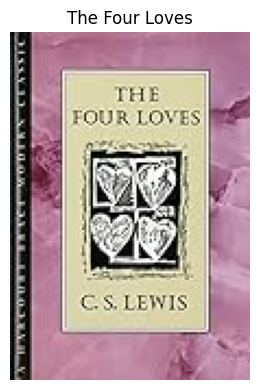

Такие рекомендации


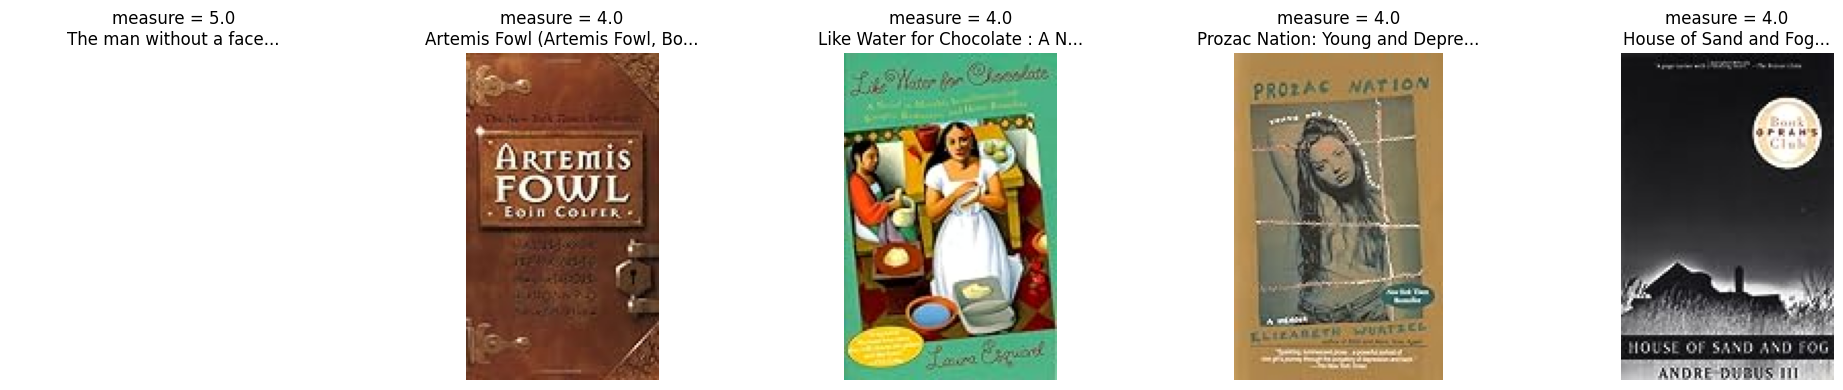

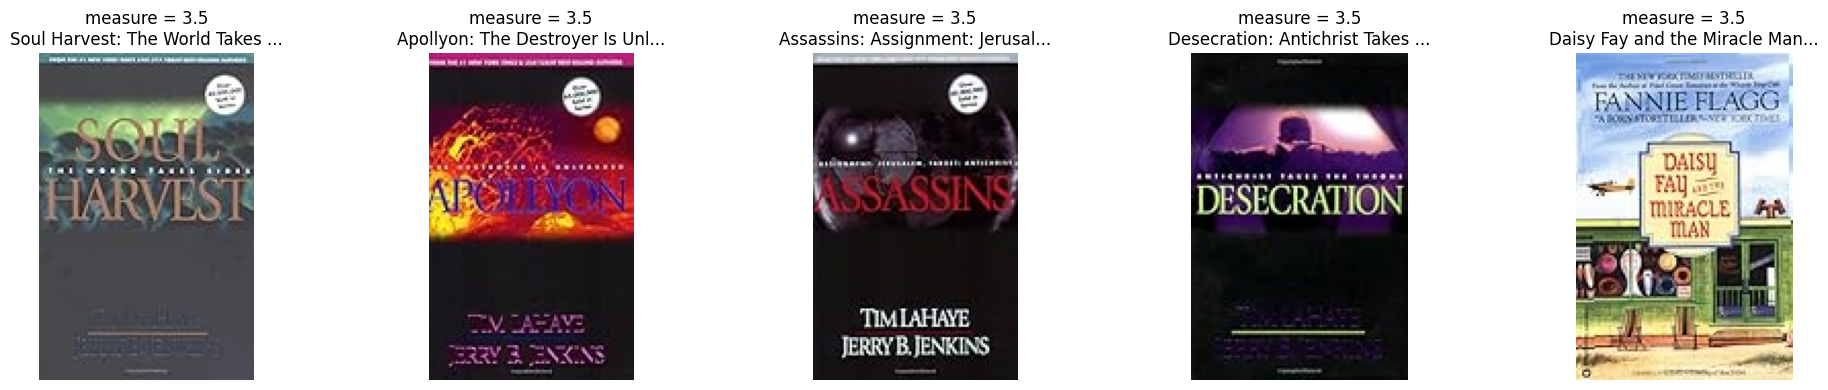

In [91]:
model.get_rec(22025)